In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
!pip install shap 
import shap


     |████████████████████████████████| 358kB 6.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=6d8a0ba87b71c1ddf2c6cfea90903d0e9d98f765be4d4a7541476bf2f6a16314
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns 

from time import sleep
from datetime import datetime

### 
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
###

from pathlib import Path

proj_path = 'drive/MyDrive/6.871 Project Team Folder/'
personal_path = proj_path + 'Eileen Data/'

RNA_RANK = 100
METHYL_RANK = 100

#cleaned_data_path = personal_path + 'censored_top{}rna{}methyl_microenv.csv'.format(RNA_RANK, METHYL_RANK)

cleaned_data_path = personal_path + 'censored_overlap_microenv.csv'

#Model Training 

- logistic regression
- random forest 
- XGboost 

## Feature Selection

In [9]:
data_df = pd.read_csv(cleaned_data_path)
data_df.drop(columns='Unnamed: 0', inplace=True)
data_df['mutation_count'] = data_df['mutation_count'].fillna(0)
data_df.tail()

,PATIENT_ID,SEX,AGE,PRIMARY_SITE_PATIENT,RACE,SMOKING_PACK_YEARS,CLIN_N_STAGE,CLIN_T_STAGE,CLIN_M_STAGE,CLINICAL_STAGE,OS_MONTHS,BINARY_SURVIVAL,HPV_STATUS,5YR_BINARY_SURVIVAL,3YR_BINARY_SURVIVAL,1YR_BINARY_SURVIVAL,ABCA8_rna,ABO_rna,ABRA_rna,ADAMTS16_rna,AJAP1_rna,ALX1_rna,ANKRD1_rna,ASPRV1_rna,ATP13A4_rna,B4GALNT2_rna,C21orf88_rna,C6orf223_rna,C7_rna,CCNA1_rna,CFTR_rna,CHL1_rna,CLDN17_rna,CLGN_rna,CNTN1_rna,COBL_rna,COL21A1_rna,CPA6_rna,CP_rna,CRABP1_rna,...,FAM184B_methyl,GALNT5_methyl,ABCA8_methyl,purity,ploidy,mutation_count_protected,pyclone_protected_hg38_vcf_nb_clones,pyclone_protected_hg38_vcf_clonal_prop,pyclone_protected_hg38_vcf_smallest_vaf,pyclone_protected_hg38_vcf_shannon_index,pyclone_protected_hg38_vcf_most_populated_clone_vaf,B cells,Blood vessels,CD8 T cells,Cytotoxic cells,DC,Eosinophils,Lymph vessels,Macrophages,Mast cells,NK CD56bright cells,NK CD56dim cells,NK cells,Neutrophils,Normal mucosa,SW480 cancer cells,T cells,T helper cells,TFH,TReg,Tcm,Tem,Tgd,Th1 cells,Th17 cells,Th2 cells,aDC,iDC,pDC,mutation_count
433,TCGA-UF-A7JT,Female,72,Floor of mouth,WHITE,NaN,N0,T4a,M0,Stage IVA,32.62,1,0,1,1,0,-2.914661,-4.645924,-4.095972,-1.571318,-1.739704,1.569714,0.005410,5.241212,-0.105291,-5.545719,-5.545719,-2.273994,-1.930373,-1.653056,-5.545719,-4.095972,2.582471,-2.914661,3.453781,1.016622,-0.256799,1.533224,-0.985163,-3.698764,...,0.431580,0.618141,0.768487,0.29,4.136505,513,1.0,100.000000,0.999586,0.000000,0.999586,7.125704,9.589832,10.434405,9.006048,7.588975,7.578036,10.109839,9.980318,4.690458,8.609375,6.833526,8.854102,7.864974,10.314625,9.942515,9.067970,10.714304,8.229274,8.948880,9.100934,9.261703,5.484112,8.936638,4.750517,8.746461,10.009358,8.291730,8.899365,16.0
434,TCGA-UF-A7JV,Female,62,Hypopharynx,WHITE,NaN,N2c,T4a,M0,Stage IVA,2.96,1,0,1,1,1,-1.619289,-1.692166,-4.240107,-0.493479,0.328219,-3.307302,-1.089882,-1.493470,-2.598116,-1.301641,-1.420445,-1.768920,-2.909564,4.879074,-4.760865,1.029368,-5.583799,0.656397,-1.935885,1.029368,2.162947,-0.339201,2.623740,-5.583799,...,0.184171,0.094811,0.703787,0.41,2.139104,228,2.0,96.491228,0.304371,0.152005,0.999132,5.989152,9.057637,10.399130,7.736094,8.005082,7.700693,8.553423,10.210945,5.498631,8.527009,5.975930,8.773754,8.170508,10.742077,9.961033,7.710013,10.696636,7.941939,9.064276,9.522097,9.440060,5.416388,8.818538,4.558979,8.695090,8.464090,8.883187,8.939823,5.0
435,TCGA-UP-A6WW,Male,58,Oral Tongue,LATINO,NaN,N2c,T2,MX,Stage IVA,17.02,0,1,-1,-1,0,-1.470776,-5.437870,-4.178327,0.587464,-1.234074,2.704907,-4.674714,0.908544,1.980777,4.270923,0.748036,3.391249,-1.289701,-2.322138,-0.895154,0.508121,-5.437870,5.585307,3.187347,-4.178327,3.371231,-2.882103,1.340556,0.159160,...,0.015155,0.097989,0.162766,0.80,1.800427,147,2.0,80.000000,0.279609,0.500402,0.999378,7.103642,8.685738,9.963105,7.566065,7.605508,7.681422,7.509450,9.066972,6.423828,8.638822,6.146505,8.810458,6.840514,10.760509,10.114533,7.820852,10.670973,8.112180,9.597000,9.076378,9.371545,4.310601,7.583214,5.902602,8.782355,8.121669,9.057447,9.053962,0.0
436,TCGA-WA-A7GZ,Male,58,Floor of mouth,WHITE,20.0,N0,T2,M0,Stage II,20.53,1,0,1,1,0,5.253143,3.537264,6.339071,-2.055025,-0.899840,-1.276116,3.605937,1.863178,5.264271,0.820785,-5.705009,-3.067028,2.028413,-1.560310,0.349592,3.916871,1.750999,2.808995,2.625568,6.382271,3.715395,-3.870136,1.181193,-0.266649,...,0.062557,0.578208,0.717535,0.43,3.637170,604,1.0,100.000000,0.980668,0.000000,0.980668,5.884335,8.425095,9.738513,6.480844,7.158924,7.828342,8.611239,8.509763,6.333599,8.834502,5.547766,8.515728,6.722459,10.685757,10.732020,6.250940,10.327467,7.732918,7.161875,9.470309,9.560411,4.027635,7.125812,4.179520,8.981270,8.649308,8.487441,6.951138,11.0
437,TCGA-WA-A7H4,Male,69,Oral Tongue,WHITE,25.0,N0,T2,M0,Stage II,14.55,0,0,-1,-1,0,1.850538,1.817608,-0.252839,0.860660,3.971964,-5.299470,5.592343,1.254333,1.502426,-0.653399,1.013878,-2.127494,2.004779,2.442948,3.356038,5.741347,-3.227295,-0.960988,1.013878,4.843668,3.230312,-2.1274

In [10]:
categorical_features = ['SEX', 'PRIMARY_SITE_PATIENT', 'RACE', 'CLIN_N_STAGE', 'CLIN_T_STAGE', 'CLIN_M_STAGE', 'CLINICAL_STAGE']
omit_features = [
                 'RACE', 
                 'CLIN_N_STAGE', 
                 'CLIN_T_STAGE', 
                 'CLIN_M_STAGE', 
                 'CLINICAL_STAGE',
                 'PRIMARY_SITE_PATIENT',
                 ]

present_categorical_feat = list(set(categorical_features) - set(omit_features))

dropped_data = data_df.drop(columns = omit_features)
num_columns = dropped_data.columns.difference(present_categorical_feat)

cat_feat = pd.get_dummies(dropped_data[present_categorical_feat])
num_feat = dropped_data[num_columns].replace('[Not Available]', np.nan)
final_df = pd.concat([cat_feat, num_feat], axis=1).drop(columns='SEX_Male')

#CATEGORICAL FEATURES ONE-HOTTED 
one_hot_cat_feat = list(set(cat_feat.columns) - set(['SEX_Male']))

final_df.tail()

,SEX_Female,1YR_BINARY_SURVIVAL,3YR_BINARY_SURVIVAL,5YR_BINARY_SURVIVAL,ABCA8_methyl,ABCA8_rna,ABO_methyl,ABO_rna,ABRA_methyl,ABRA_rna,ADAMTS16_methyl,ADAMTS16_rna,AGE,AJAP1_methyl,AJAP1_rna,ALX1_methyl,ALX1_rna,ANKRD1_methyl,ANKRD1_rna,ASPRV1_methyl,ASPRV1_rna,ATP13A4_methyl,ATP13A4_rna,B cells,B4GALNT2_methyl,B4GALNT2_rna,BINARY_SURVIVAL,Blood vessels,C21orf88_methyl,C21orf88_rna,C6orf223_methyl,C6orf223_rna,C7_methyl,C7_rna,CCNA1_methyl,CCNA1_rna,CD8 T cells,CFTR_methyl,CFTR_rna,CHL1_methyl,...,T cells,T helper cells,TAGLN3_methyl,TAGLN3_rna,TCHH_methyl,TCHH_rna,TFH,THBS4_methyl,THBS4_rna,THSD7B_methyl,THSD7B_rna,TNFRSF17_methyl,TNFRSF17_rna,TRIM58_methyl,TRIM58_rna,TReg,Tcm,Tem,Tgd,Th1 cells,Th17 cells,Th2 cells,VTCN1_methyl,VTCN1_rna,WISP3_methyl,WISP3_rna,ZIC1_methyl,ZIC1_rna,aDC,iDC,mutation_count,mutation_count_protected,pDC,ploidy,purity,pyclone_protected_hg38_vcf_clonal_prop,pyclone_protected_hg38_vcf_most_populated_clone_vaf,pyclone_protected_hg38_vcf_nb_clones,pyclone_protected_hg38_vcf_shannon_index,pyclone_protected_hg38_vcf_smallest_vaf
433,1,0,1,1,0.768487,-2.914661,0.421844,-4.645924,0.774741,-4.095972,0.557044,-1.571318,72,0.398115,-1.739704,0.469249,1.569714,0.410326,0.005410,0.744787,5.241212,0.910443,-0.105291,7.125704,0.949886,-5.545719,1,9.589832,0.099040,-5.545719,0.304638,-2.273994,0.673303,-1.930373,0.478591,-1.653056,10.434405,0.660211,-5.545719,0.517722,...,9.067970,10.714304,0.762222,-4.645924,0.139187,-1.653056,8.229274,0.586178,4.328744,0.674234,-5.545719,0.779746,1.081237,0.017671,2.449957,8.948880,9.100934,9.261703,5.484112,8.936638,4.750517,8.746461,0.836720,-1.653056,0.908228,0.989942,0.711412,-2.725928,10.009358,8.291730,16.0,513,8.899365,4.136505,0.29,100.000000,0.999586,1.0,0.000000,0.999586
434,1,1,1,1,0.703787,-1.619289,0.093786,-1.692166,0.701119,-4.240107,0.134842,-0.493479,62,0.489235,0.328219,0.162594,-3.307302,0.224034,-1.089882,0.968841,-1.493470,0.846330,-2.598116,5.989152,0.767864,-1.301641,1,9.057637,0.027879,-1.420445,0.625254,-1.768920,0.736010,-2.909564,0.122898,4.879074,10.399130,0.318001,-4.760865,0.660487,...,7.710013,10.696636,0.177012,4.372999,0.165251,-0.862579,7.941939,0.295235,1.631975,0.711992,-3.094770,0.818883,-4.760865,0.497543,-2.124734,9.064276,9.522097,9.440060,5.416388,8.818538,4.558979,8.695090,0.707097,1.127919,0.978456,-3.556645,0.058529,-4.240107,8.464090,8.883187,5.0,228,8.939823,2.139104,0.41,96.491228,0.999132,2.0,0.152005,0.304371
435,0,0,-1,-1,0.162766,-1.470776,0.696434,-5.437870,0.888353,-4.178327,0.855501,0.587464,58,0.683882,-1.234074,0.852485,2.704907,0.782734,-4.674714,0.979494,0.908544,0.916400,1.980777,7.103642,0.099019,4.270923,0,8.685738,0.021011,0.748036,0.167673,3.391249,0.862717,-1.289701,0.568192,-2.322138,9.963105,0.902552,-0.895154,0.148740,...,7.820852,10.670973,0.911512,-2.882103,0.580004,-0.811338,8.112180,0.771580,4.412743,0.501506,-3.516282,0.279637,1.035192,0.739039,-3.064194,9.597000,9.076378,9.371545,4.310601,7.583214,5.902602,8.782355,0.129118,0.508121,0.937224,-3.064194,0.904268,2.282061,8.121669,9.057447,0.0,147,9.053962,1.800427,0.80,80.000000,0.999378,2.0,0.500402,0.279609
436,0,0,1,1,0.717535,5.253143,0.555219,3.537264,0.741581,6.339071,0.024072,-2.055025,58,0.038365,-0.899840,0.602044,-1.276116,0.288845,3.605937,0.472447,1.863178,0.937631,5.264271,5.884335,0.943694,0.820785,1,8.425095,0.024955,-5.705009,0.317505,-3.067028,0.369351,2.028413,0.374296,-1.560310,9.738513,0.727509,0.349592,0.143190,...,6.250940,10.327467,0.792752,-5.705009,0.582392,0.556864,7.732918,0.106939,7.218676,0.323569,1.026490,0.405539,-5.705009,0.016907,1.232409,7.161875,9.470309,9.560411,4.027635,7.125812,4.179520,8.981270,0.534298,-4.513699,0.924773,-3.870136,0.378775,0.349592,8.649308,8.487441,11.0,604,6.951138,3.637170,0.43,100.000000,0.980668,1.0,0.000000,0.980668
437,0,0,-1,-1,0.493018,1.850538,0.042754,1.817608,0.644214,-0.252839,0.063285,0.860660,69,0.105538,3.971964,0.164637,-5.299470,0.487516,5.592343,0.753658,1.254333,0.831135,1.502426,7.4

In [11]:
print(one_hot_cat_feat)

['SEX_Female']


## Training

In [22]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def preprocess_pipeline(impute_missing_val=True):
  categorical_features = one_hot_cat_feat
  categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
        ])

  numeric_features = list(set(X.columns) - set(one_hot_cat_feat))

  if impute_missing_val:
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
        ])
  else: 
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
        ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, one_hot_cat_feat)
          ])
  return preprocessor 

def cv_pipeline(X, y, clf, scoring='roc_auc' , impute=True):
  preprocessor = preprocess_pipeline(impute_missing_val= impute)
  pipeline = Pipeline([('preproc', preprocessor), ('estimator', clf)])

  cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
  return np.mean(cv_results['test_score'])

LABELS = ['PATIENT_ID','BINARY_SURVIVAL', 'OS_MONTHS', '5YR_BINARY_SURVIVAL', '3YR_BINARY_SURVIVAL', '1YR_BINARY_SURVIVAL']
TARGET = '3YR_BINARY_SURVIVAL'

censored_df = final_df[~(final_df[TARGET] ==-1)]

X, y = censored_df.drop(columns=LABELS), censored_df[TARGET]


rfc_clf = RandomForestClassifier(n_estimators=250, max_depth=5, min_samples_leaf=10)
print("rfc roc_score:", cv_pipeline(X, y, rfc_clf))

lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', C=.1, class_weight='balanced')
print("lr roc_score:", cv_pipeline(X, y, lr_l1_clf))

XGB_clf = XGBClassifier()
print("xgb roc_score:", cv_pipeline(X, y, XGB_clf, impute=False))

rfc roc_score: 0.6216039426523297
lr roc_score: 0.6057885304659498
xgb roc_score: 0.6134856630824372


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


def fit_pipeline(X, y, clf, scoring='roc_auc', impute=True):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)
  preprocessor = preprocess_pipeline(impute_missing_val=impute)
  pipeline = Pipeline([('preproc', preprocessor), ('estimator', clf)])

  pipeline.fit(X_train, y_train)
  
  print(pipeline.score(X_test, y_test))
  return pipeline 

censored_df = final_df[~(final_df[TARGET] ==-1)]

X, y = censored_df.drop(columns=LABELS), censored_df[TARGET]

lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', C=.1, class_weight='balanced')
print("single lr roc_score:")
lr_pipe = fit_pipeline(X, y, lr_l1_clf)

rfc_clf = RandomForestClassifier(n_estimators=250, max_depth=5)
print("single rfc roc_score:")
rfc_pipe = fit_pipeline(X, y, rfc_clf)

XGB_clf = XGBClassifier()
print("xgb roc_score:")
xgb_pipe = fit_pipeline(X, y, XGB_clf, impute=False)


single lr roc_score:
0.5454545454545454
single rfc roc_score:
0.6727272727272727
xgb roc_score:
0.6


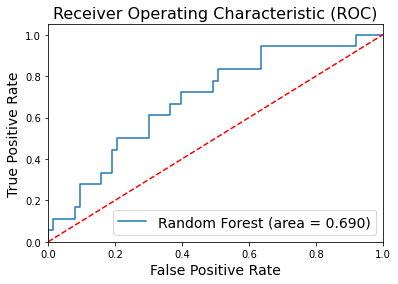

In [22]:
X, y = censored_df.drop(columns=LABELS), censored_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)
clf = rfc_pipe

rf_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('RF_ROC', fontsize=14)
plt.show();

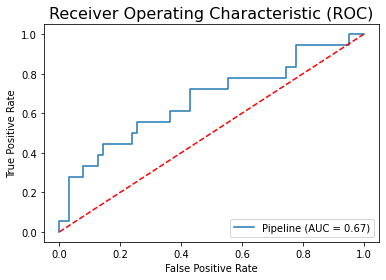

In [ ]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt  

plot_roc_curve(clf, X_test, y_test) 
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

# Logistic Regression Analysis 

In [24]:
coeffsdict = {}
coeffs = lr_l1_clf.coef_[0]
print(len(coeffs))
print(len(X.columns))

261
261


In [25]:
coef_list = [ (val, label) for (val, label) in zip(coeffs, X.columns) if val != 0]
coef_list = sorted(coef_list, key=lambda item: abs(item[0]),  reverse=True)
print("survival determining", coef_list)


survival determining [(0.2723639537512576, 'TCHH_methyl'), (-0.24719671974600915, 'SERPINA3_methyl'), (0.12675585768270334, 'MMP3_methyl'), (-0.12362383401133062, 'SLC9A2_rna'), (0.09879685653633812, 'MPPED2_rna'), (0.09594168925407247, 'GSTA1_rna'), (-0.09574629863145244, 'Th17 cells'), (-0.08477411013929771, 'SLC9A2_methyl'), (-0.07986726316363585, 'FLG2_rna'), (-0.0767353386599116, 'GRIN2A_methyl'), (-0.07661950388446148, 'ABO_methyl'), (-0.0754698847631433, 'AJAP1_methyl'), (0.07034452094610188, 'Mast cells'), (0.06056995779310424, 'NK CD56bright cells'), (0.04856331883892133, 'MYLPF_methyl'), (0.04255855518888459, 'SEX_Female'), (0.039766829814597865, 'OGDHL_rna'), (-0.035690026796980794, 'CLGN_methyl'), (-0.035624239769113344, 'B cells'), (0.035329130994947985, 'MUC15_rna'), (0.031101137439301034, 'B4GALNT2_rna'), (-0.02746072076054449, 'TCHH_rna'), (-0.018076383970589856, 'NKX2-3_rna'), (-0.015706608495163178, 'IRX1_rna'), (0.009755011767690665, 'COBL_methyl'), (0.00631427950016

In [26]:
non_0_weight_methyl = [item[1][:-7] for item in coef_list if '_methyl' in item[1]]
weights_methyl =  [item[0] for item in coef_list if '_methyl' in item[1]]
print("methylation", non_0_weight_methyl)
#print("weights", weights_methyl)
non_0_weight_rna = [item[1][:-4] for item in coef_list if '_rna' in item[1]]
weights_rna = [item[0] for item in coef_list if '_rna' in item[1]]
print("rna", non_0_weight_rna)
non_0_other = [item[1] for item in coef_list if not ('_rna' in item[1] or '_methyl' in item[1]) ]
print("other", non_0_other)

methylation ['TCHH', 'SERPINA3', 'MMP3', 'SLC9A2', 'GRIN2A', 'ABO', 'AJAP1', 'MYLPF', 'CLGN', 'COBL', 'LCE1C', 'EYA4']
rna ['SLC9A2', 'MPPED2', 'GSTA1', 'FLG2', 'OGDHL', 'MUC15', 'B4GALNT2', 'TCHH', 'NKX2-3', 'IRX1']
other ['Th17 cells', 'Mast cells', 'NK CD56bright cells', 'SEX_Female', 'B cells']


In [18]:
methyl_genes = pd.DataFrame(data=non_0_weight_methyl, columns=['methyl_100_100'])
rna_genes = pd.DataFrame(data=non_0_weight_rna, columns=['rna_100_100'])
other_important = pd.DataFrame(data=non_0_weight_rna, columns=['other_important'])
merge_genes = pd.concat([methyl_genes, rna_genes], axis=1)
merge_genes.head()

,methyl_100_100,rna_100_100
0,TCHH,ANKRD1
1,CLDN17,MPPED2
2,GPR110,SHANK2
3,ABO,OGDHL
4,CLGN,CYP26A1


In [ ]:
merge_genes.to_csv(personal_path + 'censored_LR_important.csv', index=False)

#XGBoost Analysis 

In [20]:
explainer = shap.TreeExplainer(XGB_clf)
shap_values = explainer(X)

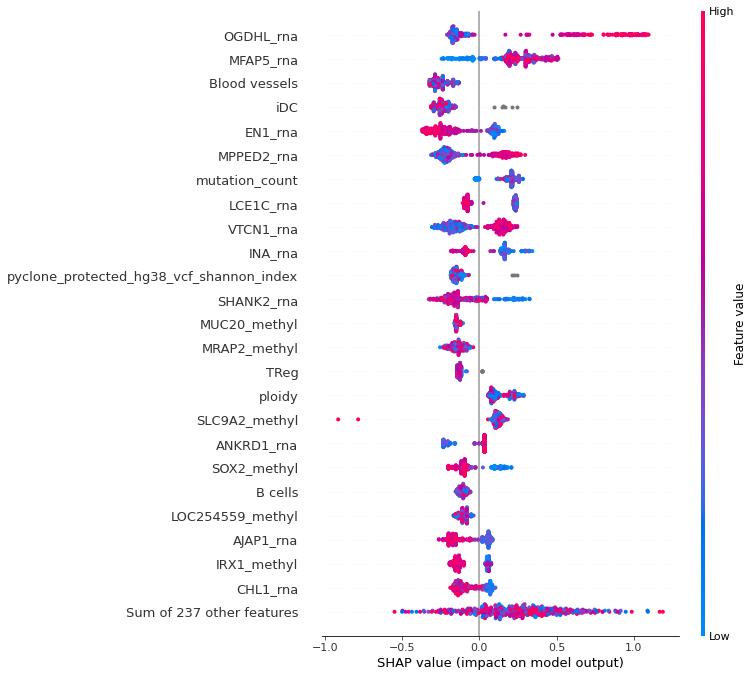

In [21]:
shap.plots.beeswarm(shap_values, max_display=25)

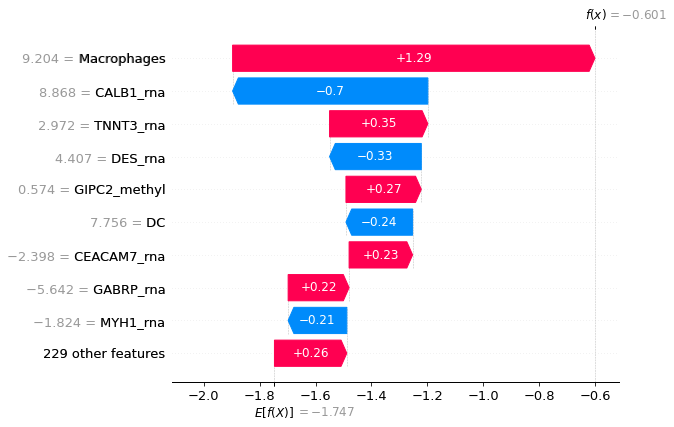

In [ ]:
shap.plots.waterfall(shap_values[0])

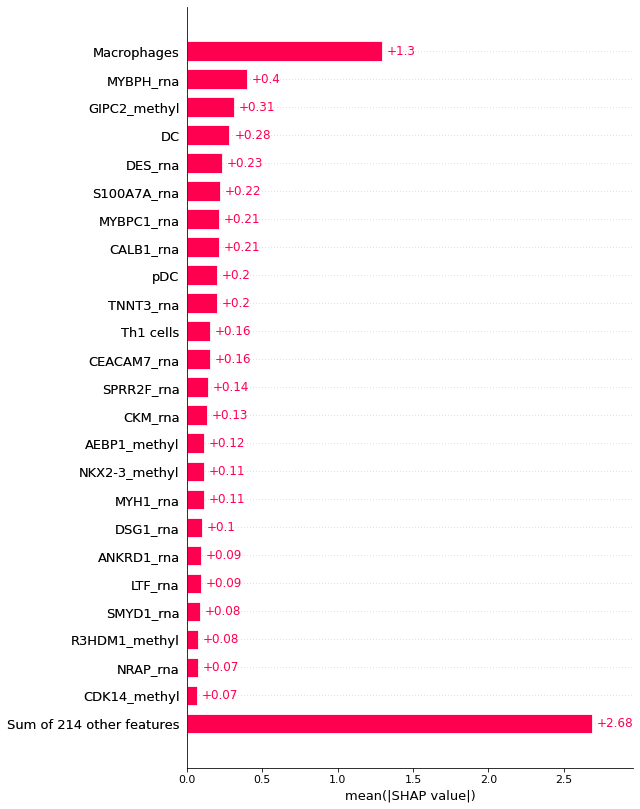

In [ ]:
shap.plots.bar(shap_values, max_display=25)

# RFC analysis 

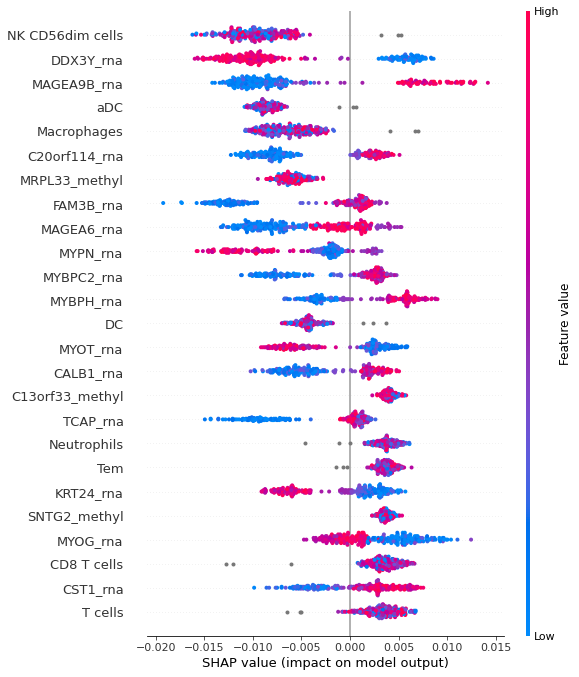

In [62]:
explainer = shap.TreeExplainer(rfc_clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X, max_display=25)

In [ ]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values)[0,:, 1])), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

def sort_importance(feature_importance):
  feature_importance['RNA'] = feature_importance['features'].apply(lambda x: x[:-4] if '_rna' in x else np.nan)
  feature_importance['Methyl'] = feature_importance['features'].apply(lambda x: x[:-7] if '_methyl' in x else np.nan)
  feature_importance['Other'] = feature_importance['features'].apply(lambda x: x if not('_methyl' in x or '_rna' in x) else np.nan)
  ranked_importance = feature_importance.reset_index().drop(columns='index')
  return ranked_importance

feature_importance = global_shap_importance(rfc_clf, X)
rfc_import_df = sort_importance(feature_importance)
rfc_import_df.head()

,features,importance,RNA,Methyl,Other
0,Neutrophils,0.025273,NaN,NaN,Neutrophils
1,NK CD56bright cells,0.020220,NaN,NaN,NK CD56bright cells
2,DDX3Y_rna,0.014945,DDX3Y,NaN,NaN
3,MUC21_rna,0.014121,MUC21,NaN,NaN
4,ADH7_rna,0.012821,ADH7,NaN,NaN


In [ ]:
rfc_import_df.to_csv(personal_path+'1yr_rfc_shap_importance.csv')